# 🧪 Classification pipeline with RDF

### **About This Exercise**

Today you will not have any tasks to solve instead you should solve this challenge completely to practice what we have learned so far.

You’ll work with `data.csv`, which contain clinical and pathological data for cancer diagnoses. Each case includes measurements of three cell nuclei (radius, texture, perimeter), along with patient age, diagnosis date, treatment start date, and cancer type.

### **Context**

The task is to classify tissue samples as cancerous or healthy using features extracted by a pathologist. You'll build a machine learning pipeline that preprocesses this data and applies classification models to make accurate predictions. You should finally build a ML for the production phase.


### **Goal**

Your objectives:

* Preprocess the data with various cleaning and transformation methods.
* Build and tune a Random Forest (RDF) classifier.
* Experiment with different hyperparameter settings
* try to reduce n_estimators to 10 , what will happen?
* you must understand all RDF options so please spend some time reading the function signature

To ensure reproducibility, document your preprocessing and modeling options early in the notebook. Recommended practices include:

* **Dictionary in Notebook**: Simple and effective for small projects.
* **JSON Config File**: Useful for managing and reusing configurations.
* **MLflow Tracking**: Best for logging experiments, metrics, and comparing results visually.

These practices support consistent and trackable machine learning workflows.

#### Dictionarys you can use to save the options for the preprocessing and modeling. 

In [1]:
# Configuration dictionary to track preprocessing and modeling choices
config = {
    "missing_value_strategy": "replace_by_mean_cancer_type",  # Options: replace_by_med_cancer_type, replace_by_mean_cancer_type
    "scaling_method": "StandardScaler",                       # Options: StandardScaler, RobustScaler, normalizer, MinMaxScaler
    "RDF": {"n_estimators": 1000, # options: 5, 10, 100
            "max_depth": 6,       # options: None, 2, 6
            "min_samples_split":2, # options: 2, 4, 10
            "min_samples_leaf":2, # options: 2, 4, 10
            "max_features":0.7,
            "class_weight":'balanced'}                         
}

#### Improt needed packages and set the random seed

In [2]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model and preprocessing tools will be added as needed later


In [3]:
# Set global random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### Read and check the data

In [4]:
data = pd.read_csv('./data.csv',header='infer')

In [5]:
data.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.3070874472,82.366936,44,2006-06-03,2005-10-23,0
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.8551305385,103.078286,59,2004-02-22,2007-08-20,1
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.0971528265,143.367792,37,2006-01-06,2004-08-07,0
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.4992370844,65.920413,51,2003-04-14,2005-06-16,1
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.8566873539,108.380754,21,2004-06-21,2002-11-27,1


In [6]:
data.cancer_type.value_counts()

cancer_type
1    250
0    148
Name: count, dtype: int64

In [7]:
data.describe()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,perimeter_2,age,cancer_type
count,398.000000,398.000000,398.000000,343.000000,398.000000,264.000000,398.000000,398.000000,398.000000,398.000000
mean,21.303711,18.957554,92.128890,14.123575,30.417222,94.086379,14.134922,127.222422,39.876884,0.628141
std,49.987646,6.243499,25.159787,3.780636,15.027855,27.314466,3.748146,49.097558,13.427196,0.483909
min,6.401956,-17.243202,45.612505,5.752395,2.395868,43.444930,7.079847,44.918942,18.000000,0.000000
25%,11.693885,14.581364,74.975361,11.600838,19.898062,75.188880,11.573592,84.123724,28.000000,0.000000
50%,13.468170,18.238742,87.376764,13.385789,30.897762,90.054613,13.333610,129.992697,39.000000,1.000000
75%,16.323024,22.494291,104.876420,16.051640,42.555657,106.085670,16.093900,169.538170,50.000000,1.000000
max,561.311068,40.064462,193.755763,29.645166,55.820612,227.162938,28.563252,214.192377,64.000000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        398 non-null    float64
 1   texture_0       398 non-null    float64
 2   perimeter_0     398 non-null    float64
 3   radius_1        343 non-null    float64
 4   texture_1       398 non-null    float64
 5   perimeter_1     264 non-null    float64
 6   radius_2        398 non-null    float64
 7   texture_2       398 non-null    object 
 8   perimeter_2     398 non-null    float64
 9   age             398 non-null    int64  
 10  treatment_date  398 non-null    object 
 11  diagnose_date   398 non-null    object 
 12  cancer_type     398 non-null    int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 40.5+ KB


### Data cleaning

convert texture_2 to numeric using pd.to_numeric function

In [9]:
data['texture_2'] = pd.to_numeric(data['texture_2'], errors='coerce')

In [10]:
data['texture_2'].unique()

array([27.30708745, 17.85513054, 21.09715283, 16.49923708, 19.85668735,
               nan, 20.96262316, 24.05563979, 16.90834175, 11.93493818,
       23.74443325, 16.7766637 , 34.48583447, 28.03048323, 13.48464825,
       28.56350253, 22.42551429, 22.81459615,  6.28832763, 24.16677213,
       15.91833199, 19.60271406, 14.07485377, 21.51172107, 21.19413943,
       16.20494059,  9.61456785, 14.38762103, 12.22111965, 22.4458738 ,
       20.36478244, 23.2419935 , 26.76098904, 18.68860096, 21.51648463,
       22.53935042, 18.14563634, 10.76352521, 18.51075595, 20.66829916,
       12.94236501, 15.8371942 , 16.32137114, 13.43212738, 30.58043455,
       22.2661324 , 16.90612834,  8.74385531, 22.98456156, 21.92498037,
       18.2055689 , 14.51133553, 15.10303442, 18.66248052, 26.55846941,
       20.42979912, 22.59117621, 12.37406627, 29.80782781, 23.09597228,
       16.17821635,  7.60840059,  3.37671582, 22.56030116, 22.95653423,
       17.76828125, 10.41273388, 14.55407678, 16.70099378, 12.49

In [11]:
data.isnull().sum()

radius_0            0
texture_0           0
perimeter_0         0
radius_1           55
texture_1           0
perimeter_1       134
radius_2            0
texture_2          16
perimeter_2         0
age                 0
treatment_date      0
diagnose_date       0
cancer_type         0
dtype: int64

Parse Dates to dataime data type

In [12]:
data['diagnose_date'] = pd.to_datetime(data.diagnose_date)
data['treatment_date'] = pd.to_datetime(data.treatment_date)

Adjust age if treatment happened years after diagnosis

In [13]:
mask = data['treatment_date'] > data['diagnose_date']
year_diff = data.loc[mask, 'treatment_date'].dt.year - data.loc[mask, 'diagnose_date'].dt.year
data.loc[mask, 'age'] -= year_diff

Drop treatment_date', 'diagnose_date as they are irrelevant to cancer prediction

In [14]:
data.drop(['treatment_date', 'diagnose_date'], axis=1, inplace=True)

Replacing Invalid Texture Values (the negative values) with NaN

In [15]:
# set these values to NaN
data.loc[data.texture_0 < 0, 'texture_0'] = np.nan
data.loc[data.texture_2 < 0, 'texture_2'] = np.nan

Split prior to real preprocessing

In [16]:
from sklearn.model_selection import train_test_split

features_list = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
                 'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age']

X_train, X_test, y_train, y_test = train_test_split(data[features_list], 
                                                    data['cancer_type'],
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE)

### data preprocessing

#### IMPORTANT!
To process ***test_data*** we must use the same preprocessing steps with processing parameters inferred from the ***train datae*** to ensures that both training and test data have the same statistical properties, which is crucial for fair evaluation and better generalization of the model.

##### **Example**
We use the same **scaling values** (mean and standard deviation) inferred from the training data for the test data to ensure **consistency** in preprocessing and to avoid **data leakage**. Here’s why:

##### 1. **Consistency in Feature Distribution**
- If we scale the training and test data differently, the features might end up having different ranges and distributions.
- This inconsistency can cause the model to perform poorly on the test data because the features it sees during inference are not represented in the same way as during training.

##### 2. **Avoiding Data Leakage**
- Scaling the test data using its own statistics (mean and standard deviation) would leak information about the test set into the preprocessing step.
- This results in **biased performance estimates**, as the test data is no longer truly "unseen."

##### 3. **Generalization of the Model**
- The model learns patterns based on the **scaled features** from the training data. When applying the model to new data (e.g., the test set or unseen data), we need to use the same scaling to ensure the model can generalize correctly.




#### check for outliers: use boxplot to check  to get a feeling how the data looks like. 

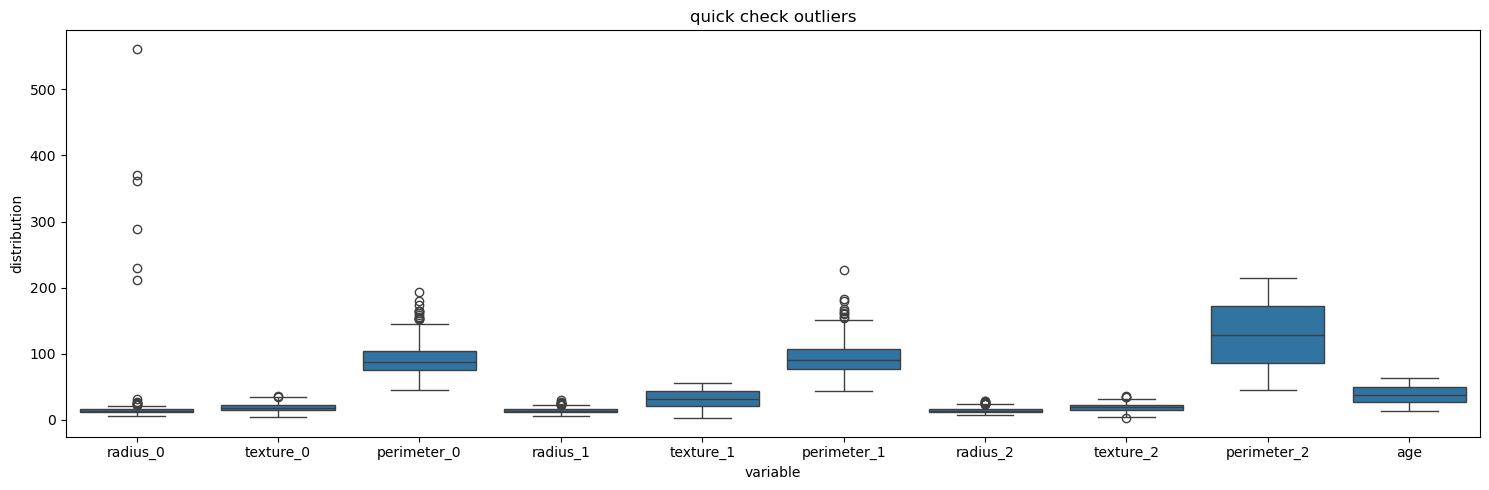

In [17]:
features_list = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
                 'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age']

fig = plt.figure(1, figsize=(15, 5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X_train))

ax.set_title("quick check outliers")
ax.set_ylabel(ylabel='distribution')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
fig.tight_layout()
plt.show() 

This is not helpful to check outliers because **Combining Different Features** with **different scales and units** (e.g., `radius` vs. `age`) can lead to be misleading representation

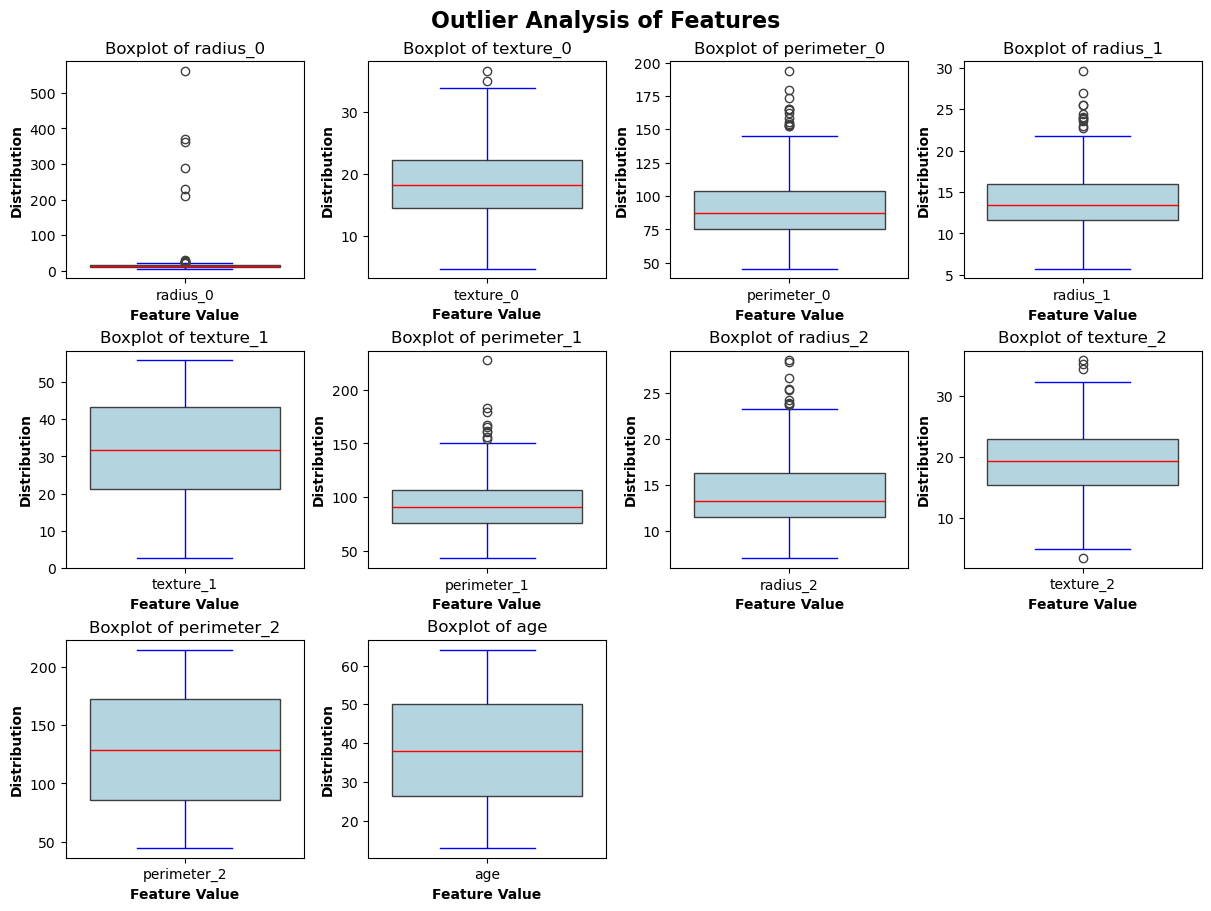

In [18]:
# Setting up the subplots
n_features = len(features_list)
n_cols = 4  # Number of columns per row
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), constrained_layout=True)

# Flatten axes for easy indexing
axes = axes.flatten()

# Plotting each feature's boxplot with corrected properties
for i, feature in enumerate(features_list):
    sns.boxplot(
        data=pd.DataFrame(X_train[feature]),
        ax=axes[i],
        color="lightblue",  # Set a consistent color without overriding boxprops
        medianprops=dict(color="red"),
        whiskerprops=dict(color="blue"),
        capprops=dict(color="blue")
    )
    
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel('Feature Value', fontweight='bold')
    axes[i].set_ylabel('Distribution', fontweight='bold')

# Hide any extra subplots if features are fewer than axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# Adjust layout
plt.suptitle("Outlier Analysis of Features", fontsize=16, fontweight='bold')
plt.show()

Use the Interquartile Range (IQR) method to replace outliers. 

**The Interquartile Range (IQR) method** is a statistical approach to identify outliers in a dataset. It calculates the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data. Data points outside the "fence" defined by Q1 - 1.5xIQR and Q3 + 1.5xIQR are considered outliers.

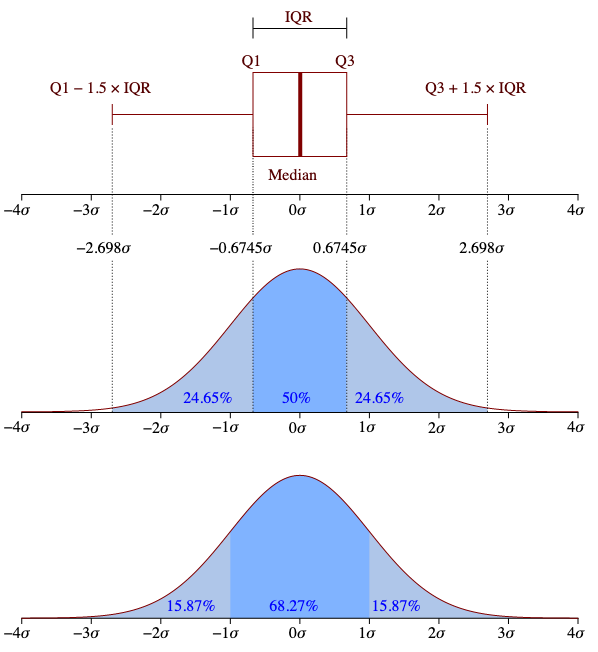

In [19]:
features_list = ['radius_0', 'texture_0', 'perimeter_0', 'radius_1', 'texture_1',
                 'perimeter_1', 'radius_2', 'texture_2', 'perimeter_2', 'age']

In [22]:
# Define the threshold for outlier detection using the IQR method
k = 1.5  # Outlier if a value is more than 1.5 * IQR below Q1 or above Q3

# Compute Q1, Q3, and IQR using the TRAINING DATA
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)

IQR = Q3 - Q1
lower_th = Q1 - IQR * k
upper_th = Q3 + IQR * k

# Create a mask identifying outliers in the selected features
outlier_mask_train = (X_train < lower_th)  | (X_train > upper_th)
outlier_mask_test = (X_test < lower_th)  | (X_test > upper_th)
X_train = X_train.where(~outlier_mask_train, np.nan)
X_test = X_test.where(~outlier_mask_test, np.nan)

# Replace outliers with NaN so they can be imputed later along with existing NaNs
# X_train = X_train.where(~outlier_mask_train, np.nan)
# X_test = X_test.where(~outlier_mask_test, np.nan)

**Better Alternatives to outliers detections**:
- **Z-score or Robust Z-score**: Standardize the features and check for outliers using a threshold.
- **Multivariate Techniques**: Use methods like **PCA**, **t-SNE**, or **Mahalanobis Distance** to detect outliers based on feature relationships.
- **IsolationForest** An unsupervised learning method designed for outlier detection.
- **Scatter Plot Matrix**: Explore pairwise relationships between features.

Missing values: different ways could be used to impute the missing values (and the outliers). Some of the fast ones are listed below.

In [23]:
X_train

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age
245,NaN,17.724917,102.354399,18.605967,47.629517,128.151753,20.036809,22.369888,57.788893,21
110,18.415069,14.327391,104.610359,16.675387,51.776705,NaN,13.165276,20.309925,133.788126,33
16,12.986264,21.463125,79.254473,13.327439,8.981956,99.308755,13.728816,28.563503,44.918942,36
66,8.631637,13.333830,51.222765,9.925485,29.561053,NaN,8.257533,NaN,106.083555,31
153,12.235954,14.202175,78.032816,14.219704,25.864371,88.023368,14.054135,13.560779,172.830449,24
...,...,...,...,...,...,...,...,...,...,...
71,12.179740,11.449835,65.170012,12.423859,52.607902,80.977483,11.507248,14.554077,86.974991,16
106,14.085689,21.359689,91.396123,15.461898,3.349190,NaN,14.708694,19.239991,118.577848,61
270,15.915507,25.839033,115.009451,19.922155,17.936735,124.407731,17.875162,23.763388,47.501397,49
348,9.491437,13.990434,65.423160,NaN,23.299551,65.029954,10.291674,18.335509,135.175582,22


In [24]:
from sklearn.impute import SimpleImputer

strategy = config['missing_value_strategy'] # a better way is to use config.get('missing_value_strategy', None)

if strategy == 'replace_by_mean_cancer_type':
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    # fit on training data only
    imp.fit(X_train)
    
elif strategy == 'replace_by_med_cancer_type':
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(X_train)
    
else:
    raise ValueError(f"Unknown missing_value_strategy: {strategy}")

# apply on both train and test
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

#### Scaling the input features

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler

scaling_method = config['scaling_method'] # config.get('scaling_method', None)

if scaling_method == 'StandardScaler':
    scaler = StandardScaler()
    
elif scaling_method == 'RobustScaler':
    scaler = RobustScaler(quantile_range=(25, 75))
    
elif scaling_method == 'normalizer':
    scaler = Normalizer(norm='l1')
    
elif scaling_method == 'MinMaxScaler':
    scaler = MinMaxScaler()
    
else:
    raise ValueError(f"Unknown scaling_method: {scaling_method}")

# Fit and transform
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train = pd.DataFrame(X_train, columns=features_list)
X_test = pd.DataFrame(X_test, columns=features_list)

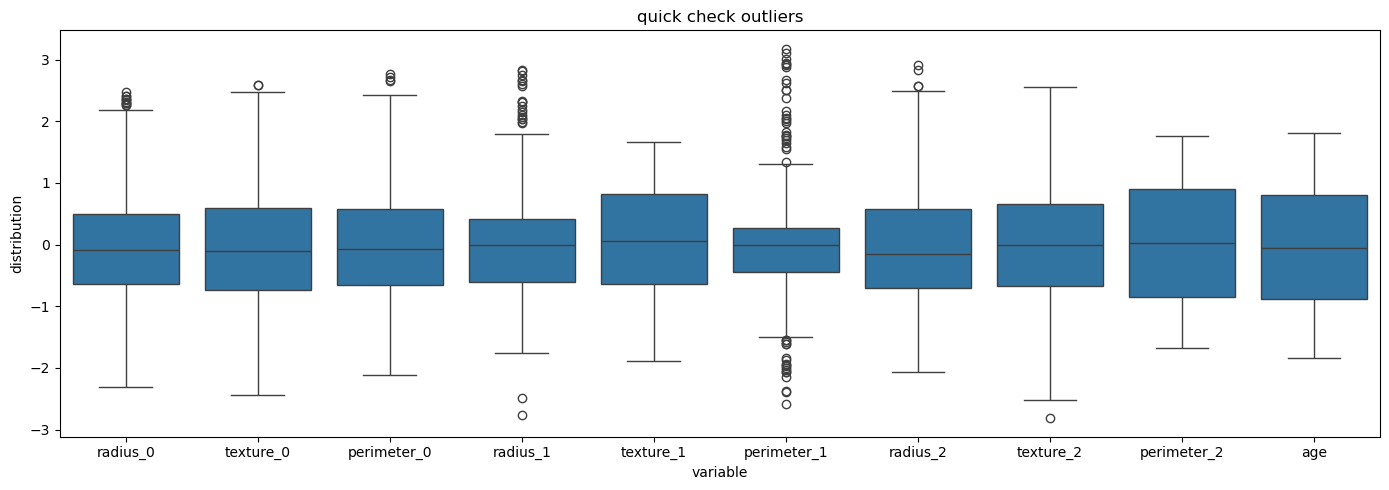

In [30]:
# it is ok now to plot them using the same scale
fig = plt.figure(1, figsize=(14, 5))

# Melt the DataFrame for boxplotting
melted = pd.melt(X_train[features_list])

ax = sns.boxplot(x="variable", y="value", data=melted)

ax.set_title("quick check outliers")
ax.set_ylabel(ylabel='distribution')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
fig.tight_layout()
plt.show() 

#### Classification with RDF model

In [32]:
config

{'missing_value_strategy': 'replace_by_mean_cancer_type',
 'scaling_method': 'StandardScaler',
 'RDF': {'n_estimators': 1000,
  'max_depth': 6,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_features': 0.7,
  'class_weight': 'balanced'}}

In [33]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier??
clf = RandomForestClassifier(n_estimators= config["RDF"]["n_estimators"], 
                             max_depth = config["RDF"]["max_depth"],
                             min_samples_split = config["RDF"]["min_samples_split"],
                             min_samples_leaf = config["RDF"]["min_samples_leaf"],
                             max_features = config["RDF"]["max_features"],
                             class_weight = config["RDF"]["class_weight"],
                             random_state=RANDOM_STATE)

#### Fit the model;  training 

In [34]:
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

#### Evaluate the model 

classification_report

In [35]:
pd.DataFrame(list(zip(y_test, y_predict)), columns=["y_test", 'y_predict'])

,y_test,y_predict
0,1,1
1,1,1
2,0,1
3,0,0
4,1,1
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict, target_names=['healthy','cancer']))

              precision    recall  f1-score   support

     healthy       0.88      0.88      0.88        40
      cancer       0.92      0.92      0.92        60

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



plot the confusion matrix

In [37]:
clf.classes_

array([0, 1], dtype=int64)

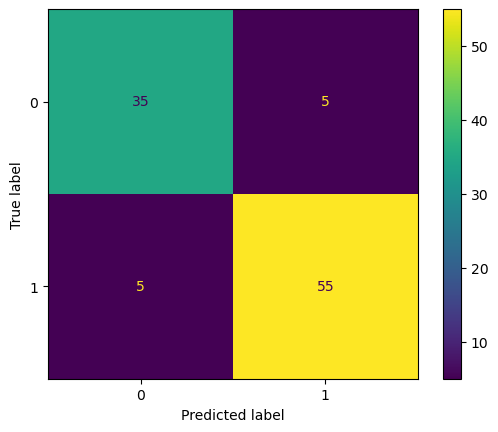

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

### Finally Train on the complete training data.

- Finally, for production use, you can train a model on the entire data set, training + validation + test set, and put it into production use. Note that you never measure the accuracy of this production model, as you don't have any remaining data for doing that; you've already used all of the data. 

- If you want an estimate of how well it will perform, you're entitled to use the estimated accuracy from previous step as your prediction of how well this will perform in production, as that's the best available prediction of its future performance. 

- As always, there are no guarantees -- that's just the best estimate possible, given the information available to us. It's certainly possible that it could do worse than you predicted, or better than you predicted -- that's always true.

In [39]:
X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
Y_all = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

In [40]:
clf.fit(X_all, Y_all)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=0.7,
                       min_samples_leaf=2, n_estimators=1000, random_state=42)

## IMPORTANT!
* Now you have a model you can use for production, or for predicting the class of feature patients. Remember that you must alway use this model, plus the preprocessing steps and paramters with the same order

* To process ***future data*** we must use the same preprocessing steps with processing parameters inferred from the ***train data***.

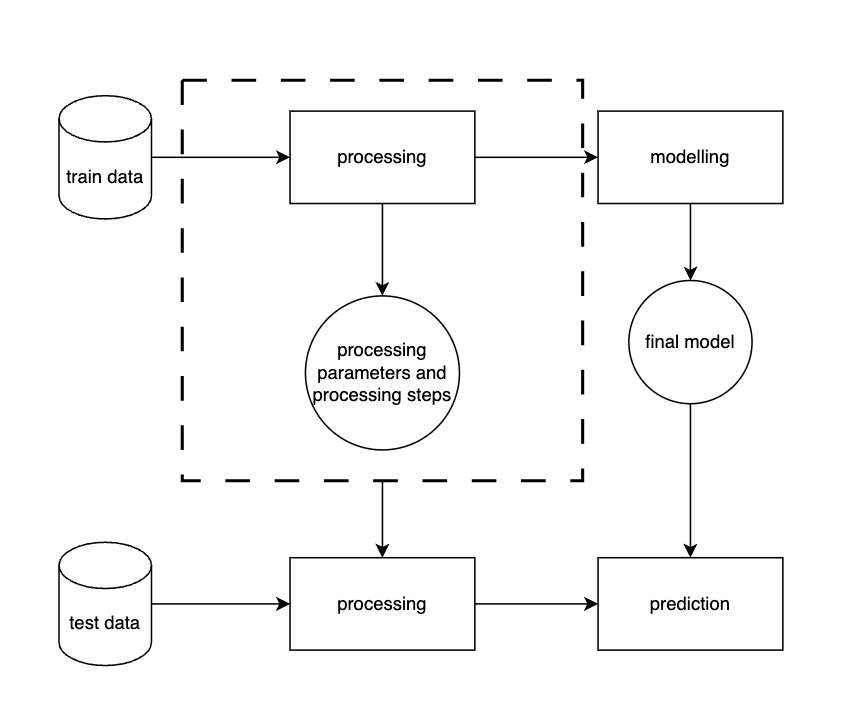
